# Import Libraries

In [1]:
# import basic libraries
import os
from os import listdir
import sys
import json
import datetime

# import advance libraries
from xml.etree import ElementTree
import skimage.draw
import cv2
import imgaug

# import mask rcnn libraries
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn import visualize

# import matplotlib library
import matplotlib.pyplot as plt

# import numpy libraries
import numpy as np
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean

# import keras libraries
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

C:\Users\Eashan\Anaconda3\envs\mask_rcnn\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
Using TensorFlow backend.


In [3]:
%matplotlib inline

# Stage-1 Training (Single Class & Bounding Box Annotations)

In Stage-1 training I used a simple dataset with images annotated using Bounding Boxes, and one class namely 'Damage'. In the following section you can find the code for training of the model. I have included comments to best desccribe the flow of the program.

In [ ]:
class DamageDataset(Dataset):
    
    # load_dataset function is used to load the train and test dataset
    def load_dataset(self, dataset_dir, is_train=True):
        
        # we add a class that we need to classify in our case it is Damage
        self.add_class("dataset", 1, "Damage")
        
        # we append the dataset_dir with /images and /annots to located images and its annotations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        
        # is_train will be true if we our training our model and false when we are testing the model
        for filename in listdir(images_dir):
            
            # extract image id
            image_id = filename[:-4]
            
            # if is_train is True skip all images with id greater than 420
            if is_train and int(image_id) >= 420 :
                continue
            
            # if is_train is not True skip all images with id less than 420
            if not is_train and int(image_id) < 420:
                continue
            
            # declaring image path and annotations path
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            
            # using add_image function we pass image_id, image_path and ann_path so that the current
            # image is added to the dataset for training
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # function used to extract bouding boxes from annotated files
    def extract_boxes(self, filename):

    # you can see how the images are annotated we extracrt the width, height and bndbox values
    
    # <size>

    #       <width>640</width>

    #       <height>360</height>

    #       <depth>3</depth>

    # </size>


    # <object>

    #          <name>damage</name>

    #          <pose>Unspecified</pose>

    #          <truncated>0</truncated>

    #          <difficult>0</difficult>


    #          <bndbox>

    #                 <xmin>315</xmin>

    #                 <ymin>160</ymin>

    #                 <xmax>381</xmax>

    #                 <ymax>199</ymax>

    #          </bndbox>

    # </object>

    # </annotation>

        tree = ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)

        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height
    
    # this function calls on the extract_boxes method and is used to load a mask for each instance in an image
    # returns a boolean mask with following dimensions width * height * instances
    def load_mask(self, image_id):

        info = self.image_info[image_id]

        path = info['annotation']

        boxes, w, h = self.extract_boxes(path)

        masks = zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('Damage'))
            
        return masks, asarray(class_ids, dtype='int32')
    
    # this functions takes the image_id and returns the path of the image
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# damage configuration class, you can change values of hyper parameters here
class DamageConfig(Config):
    # name of the configuration
    NAME = "damage_cfg"
    
    # damage class + background class
    NUM_CLASSES = 1 + 1
    
    # steps per epoch and minimum confidence
    STEPS_PER_EPOCH = 361
    
    # learning rate and momentum
    LEARNING_RATE=0.002
    LEARNING_MOMENTUM = 0.8
    
    # regularization penalty
    WEIGHT_DECAY = 0.0001
    
    # image size is controlled by this parameter
    IMAGE_MIN_DIM = 512
    
    # validation steps
    VALIDATION_STEPS = 50
    
    # number of Region of Interest generated per image
    Train_ROIs_Per_Image = 200
    
    # RPN Acnhor scales and ratios to find ROI
    RPN_ANCHOR_SCALES = (16, 32, 48, 64, 128)
    RPN_ANCHOR_RATIOS = [0.5, 1, 1.5]

# load the train dataset
train_set = DamageDataset()
train_set.load_dataset('customImages/stage-1', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# load the test dataset
test_set = DamageDataset()
test_set.load_dataset('customImages/stage-1', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

# prepare config by calling the user defined confifuration class
config = DamageConfig()
config.display()

# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)

# load weights mscoco model weights
weights_path = 'model_weights.h5'

model.load_weights(weights_path, 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

# you only need to train the head of the model
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')

# Stage-2 (Mulptiple Class and Bounding Box Annotaions)

In the stage I trained the model on multiple classes namely level-1 (scratch), level-2 (dent), level-3 (shatter), and level-4 (dislocation). The images are annotated using bounding boxes.

I recommend going through Stag-1 Training code first, there is not much difference between code of stage 1 and stage 2.

## Model Training

In [ ]:
class DamageDataset(Dataset):

    def load_dataset(self, dataset_dir, is_train=True):
        
        # we use add_class for each class in our dataset and assign numbers to them. 0 is background
        self.add_class("dataset", 1, "Level-1")
        self.add_class("dataset", 2, "Level-2")
        self.add_class("dataset", 3, "Level-3")
        self.add_class("dataset", 4, "Level-4")

        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'

        for filename in listdir(images_dir):

            image_id = filename[:-4]

            if is_train and int(image_id) >= 160 :
                continue
            
            if not is_train and int(image_id) < 160:
                continue
            
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    
    def extract_boxes(self, filename):

        tree = ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        for box in root.findall('.//object'):
            name = box.find('name').text
            xmin = int(box.find('./bndbox/xmin').text)
            ymin = int(box.find('./bndbox/ymin').text)
            xmax = int(box.find('./bndbox/xmax').text)
            ymax = int(box.find('./bndbox/ymax').text)
            coors = [xmin, ymin, xmax, ymax, name]
            
            # I have included this line to skip any un-annotated images
            if name=='Level-1' or name=='Level-2' or name=='Level-3' or name=='Level-4':
                boxes.append(coors)

        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    def load_mask(self, image_id):

        info = self.image_info[image_id]

        path = info['annotation']

        boxes, w, h = self.extract_boxes(path)

        masks = zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            
            # box[4] will have the name of the class for a particular damage
            if (box[4] == 'Level-1'):
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('Level-1'))
            elif(box[4] == 'Level-2'):
                masks[row_s:row_e, col_s:col_e, i] = 2
                class_ids.append(self.class_names.index('Level-2')) 
            elif(box[4] == 'Level-3'):
                masks[row_s:row_e, col_s:col_e, i] = 3
                class_ids.append(self.class_names.index('Level-3'))
            else:
                masks[row_s:row_e, col_s:col_e, i] = 4
                class_ids.append(self.class_names.index('Level-4'))
        return masks, asarray(class_ids, dtype='int32')

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# damage configuration class, you can change values of hyper parameters here
class DamageConfig(Config):
    # name of the configuration
    NAME = "damage_cfg"
    
    #  background class + 4 classes
    NUM_CLASSES = 1 + 4
    
    # steps per epoch and minimum confidence
    STEPS_PER_EPOCH = 160
    
    # learning rate and momentum
    LEARNING_RATE=0.002
    LEARNING_MOMENTUM = 0.8
    
    # regularization penalty
    WEIGHT_DECAY = 0.0001
    
    # image size is controlled by this parameter
    IMAGE_MIN_DIM = 512
    
    # validation steps
    VALIDATION_STEPS = 50
    
    # number of Region of Interest generated per image
    Train_ROIs_Per_Image = 200
    
    # RPN Acnhor scales and ratios to find ROI
    RPN_ANCHOR_SCALES = (16, 32, 48, 64, 128)
    RPN_ANCHOR_RATIOS = [0.5, 1, 1.5]
# prepare train set
train_set = DamageDataset()
train_set.load_dataset('customImages/stage-2', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# prepare test/val set
test_set = DamageDataset()
test_set.load_dataset('customImages/stage-2', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

# prepare config
config = DamageConfig()
config.display()
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)

# load weights mscoco model weights
weights_path = 'model_weights.h5'

model.load_weights(weights_path, 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])

model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')

# Stage 3 ( Multiple Classes and images annotated with polygon)

In this stage I have used multiple classes namely scratch, dent, shatter and dislocation. The images are annotated using a polygon. 

## Model Training

In [5]:
class DamageDataset(Dataset):

    def load_dataset(self, dataset_dir, subset):
        
        # we use add_class for each class in our dataset and assign numbers to them. 0 is background
        self.add_class("damage", 1, "Scratch")
        self.add_class("damage", 2, "Dent")
        self.add_class("damage", 3, "Shatter")
        self.add_class("damage", 4, "Dislocation")
        
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        
        # load annotations using json.load()
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_project.json")))
        
        # convert annotations1 into a list
        annotations = list(annotations1.values())  
        
        # we only require the regions in the annotations
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            
            # extracting shape attributes and region attributes
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['damage'] for s in a['regions']]
            
            # create a dictionary {name_of_class: class_id} remember background has id 0
            name_dict = {"Scratch": 1, "Dent": 2, "Shatter": 3, "Dislocation": 4}
            
            # all the ids/classes in a image
            num_ids = [name_dict[a] for a in objects]
            
            # you can print these ids
            # print("numids",num_ids)
            
            # read image and get height and width
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            
            # add image to the dataset
            self.add_image(
                "damage",
                image_id=a['filename'],
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        
        image_info = self.image_info[image_id]
        if image_info["source"] != "damage":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        if info["source"] != "damage":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

            mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "damage":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

# define a configuration for the model
class DamageConfig(Config):
    # define the name of the configuration
    NAME = "damage"
    
    # number of classes (background + damge classes)
    NUM_CLASSES = 1 + 4
    
    # number of training steps per epoch
    STEPS_PER_EPOCH = 160
    # learning rate and momentum
    LEARNING_RATE=0.002
    LEARNING_MOMENTUM = 0.8
    
    # regularization penalty
    WEIGHT_DECAY = 0.0001
    
    # image size is controlled by this parameter
    IMAGE_MIN_DIM = 512
    
    # validation steps
    VALIDATION_STEPS = 50
    
    # number of Region of Interest generated per image
    Train_ROIs_Per_Image = 200
    
    # RPN Acnhor scales and ratios to find ROI
    RPN_ANCHOR_SCALES = (16, 32, 48, 64, 128)
    RPN_ANCHOR_RATIOS = [0.5, 1, 1.5]

In [6]:
def train(model):
    # Training dataset.
    dataset_train = DamageDataset()
    dataset_train.load_dataset("customImages/stage-3", "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = DamageDataset()
    dataset_val.load_dataset("customImages/stage-3", "val")
    dataset_val.prepare()

    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=15,
                layers='heads',
                )

In [7]:
config = DamageConfig()
model = MaskRCNN(mode="training", config=config,model_dir='./')

# add mask_rcnn COOC model weights
weights_path = 'model_weights.h5'

model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


OSError: Unable to open file (unable to open file: name = 'damage20210322T1115/mask_rcnn_damage_0011.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [6]:
train(model)

numids [4, 2]
numids [4]
numids [4]
numids [4, 2]
numids [4]
numids [2]
numids [4, 1]
numids [3]
numids [4, 1]
numids [4]
numids [4]
numids [4]
numids [2]
numids [4]
numids [4]
numids [4, 2]
numids [4]
numids [3, 3]
numids [1]
numids [4, 2]
numids [4]
numids [4]
numids [4]
numids [4]
numids [4]
numids [2]
numids [4]
numids [4]
numids [4]
numids [1]
numids [4]
numids [4]
numids [4]
numids [4]
numids [1]
numids [1]
numids [1]
numids [2]
numids [1, 1]
numids [1]
numids [3, 3]
numids [1]
numids [1]
numids [1]
numids [1]
numids [1]
numids [3, 3]
numids [1]
numids [1]
numids [4]
numids [1]
numids [4]
numids [4]
numids [2]
numids [2]
numids [2]
numids [1]
numids [2]
numids [2, 1]
numids [2]
numids [2]
numids [2, 4]
numids [1]
numids [2]
numids [2, 4]
numids [2, 2]
numids [1]
numids [2, 2]
numids [2, 2]
numids [2, 4]
numids [1]
numids [2]
numids [1, 1]
numids [1]
numids [1]
numids [2, 2, 1, 1, 1, 1]
numids [1]
numids [1]
numids [1]
numids [1, 1]
numids [1, 1]
numids [1]
numids [1]
numids [1]
n

C:\Users\Eashan\Anaconda3\envs\mask_rcnn\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



Starting at epoch 0. LR=0.002

Checkpoint Path: ./damage20210415T1409\mask_rcnn_damage_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistrib

C:\Users\Eashan\Anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Eashan\Anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Eashan\Anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "






Epoch 1/15
160/160 [==============================] - 13575s 85s/step - loss: 1.5206 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.6158 - mrcnn_class_loss: 0.1252 - mrcnn_bbox_loss: 0.5020 - mrcnn_mask_loss: 0.2691 - val_loss: 3.7493 - val_rpn_class_loss: 0.0238 - val_rpn_bbox_loss: 2.6524 - val_mrcnn_class_loss: 0.1028 - val_mrcnn_bbox_loss: 0.5029 - val_mrcnn_mask_loss: 0.4674

Epoch 2/15
160/160 [==============================] - 13768s 86s/step - loss: 1.2998 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.7061 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.2994 - mrcnn_mask_loss: 0.2203 - val_loss: 3.7649 - val_rpn_class_loss: 0.0232 - val_rpn_bbox_loss: 2.7941 - val_mrcnn_class_loss: 0.0665 - val_mrcnn_bbox_loss: 0.4551 - val_mrcnn_mask_loss: 0.4260
Epoch 3/15
160/160 [==============================] - 13890s 87s/step - loss: 1.1441 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.6592 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.2309 - mrcnn_mask_loss: 0.1953 - val_loss: 3.7265 - v

KeyboardInterrupt: 

# Model Evaluation (Stage-3)

In [20]:
class PredictionConfig(Config):
    NAME = "damage"
    NUM_CLASSES = 1 + 4
    DETECTION_MIN_CONFIDENCE = 0.85
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:

        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)

        scaled_image = mold_image(image, cfg)

        sample = expand_dims(scaled_image, 0)

        yhat = model.detect(sample, verbose=0)

        r = yhat[0]

        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])

        APs.append(AP)
    maP = mean(APs)
    return mAP


train_set = DamageDataset()
train_set.load_dataset("customImages/stage-3", "train")
train_set.prepare()

    # Validation dataset
test_set = DamageDataset()
test_set.load_dataset("customImages/stage-3", "val")
test_set.prepare()

# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model.load_weights('damage20210322T1115/mask_rcnn_damage_0011.h5', by_name=True)
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP[0])
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP[1])

Train mAP: 0.889
Test mAP: 0.895


# Single Prediction (Stage-3)

In [25]:
# define a configuration for the model
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "damage"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 4
    # number of training steps per epoch
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [26]:
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model_path = 'damage20210322T1115/mask_rcnn_damage_0011.h5'
model.load_weights(model_path, by_name=True)

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


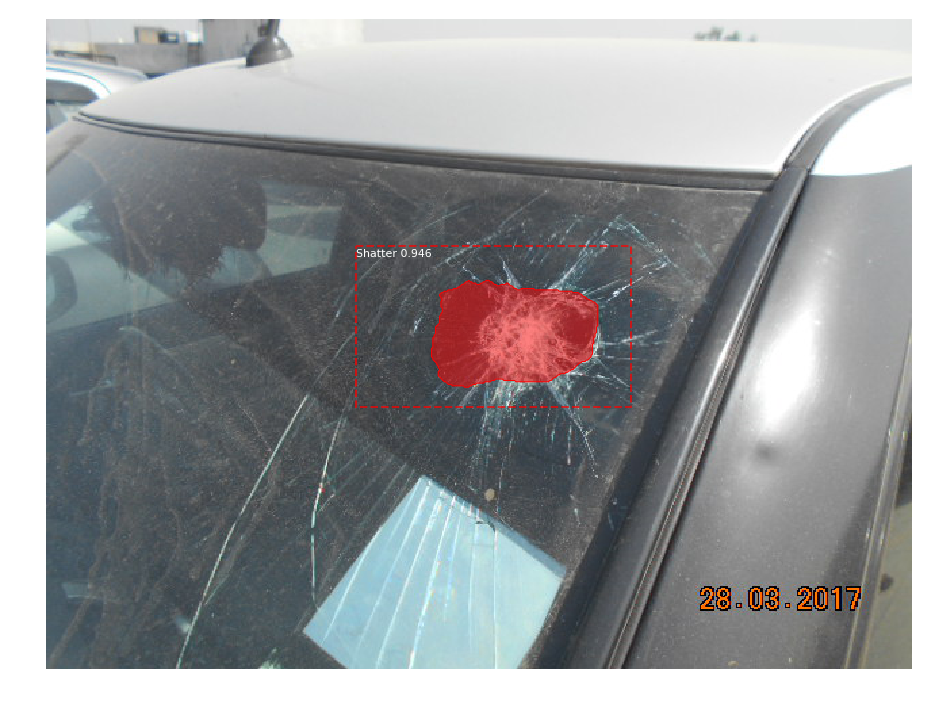

In [7]:
image = load_img("customImages/stage-3/train/117.jpg")
image = img_to_array(image)
results = model.detect([image], verbose=1)
class_names = ['BG', 'Scratch', 'Dent', 'Shatter', 'Dislocation']
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names,  r['scores'])